In [1]:
%load_ext autoreload
%autoreload 2

import itertools

from metrics.var import calculate_garch
from parsing.portfolio import Portfolio, SecurityGroup

import pandas as pd

from parsing.commodities import Brent
from parsing.currencies import Currency, __SELECTED__CURRENCIES__
from parsing.indexes import Index, __SELECTED_INDEXES__
from parsing.bonds import Bond, __SELECTED__BONDS__
from parsing.stocks import Stock, __SELECTED_STOCKS__
from parsing.zero_coupon import ZeroCoupon
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 8)})

## Зададим факторы риска

Используем следующие риск-факторы:

1) Фьючерсы на нефть марки Brent с 1, 2 и 3 месяцами до погашения
2) Валютные пары USD/RUB, EUR/RUB, CNY/RUB
3) Индексы Moex и RTSI
4) Процентные ставки за 0-30 лет

In [2]:
brent = [Brent(period=period) for period in (1, 2, 3)] # 1
currencies = [Currency(curr) for curr in __SELECTED__CURRENCIES__] # 2
indexes = [Index(idx) for idx in __SELECTED_INDEXES__] # 3
rates = ZeroCoupon() # 4

## Зададим группы инструментов

Инструменты делятся в портфеле по классу, для того чтобы считать их зависимость от факторов рисков по группам.
Выделим следующие группы:

1) Акции. 10 акций из списка голубых фишек
2) Облигации. 5 облигаций ОФЗ с фиксированным доходом
3) Валюты. 3 валюты: Доллар, Евро и Китайский юань

Также зададим следующую зависимость между факторыми:

1) Акции ~ Фьючерсы на нефть + Курсы валют + Индексы акций
2) Облигации ~ Фьючерсы на нефть + Процентные ставки
3) Валюты ~ Курсы валют

In [3]:
stocks = [Stock(st) for st in __SELECTED_STOCKS__]
bonds = [Bond(b) for b in __SELECTED__BONDS__]

In [4]:
stock_group = SecurityGroup(name='Акции', securities=stocks, factors=brent + currencies + indexes, n_components=6)
currency_group = SecurityGroup(name='Валюта', securities=currencies, factors=currencies, n_components=1)
bonds_group = SecurityGroup(name='Облигации', securities=bonds, factors=brent + [rates], n_components=6)

In [5]:
portfolio = Portfolio(name='Факторный портфель с горизонтом 1 день', periods=1, factors=brent + currencies + indexes + [rates], securities=[stock_group, currency_group, bonds_group])

## Обучение

В процессе обучения происходят следующие вещи:
1) Методом главных компонент выделяются новые риск факторы
2) Подбираются параметры для факторов риска

In [6]:
portfolio.fit()

  0%|          | 0/3 [00:00<?, ?it/s]

                            OLS Regression Results                            
Dep. Variable:             stock_ALRS   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     76.28
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           7.58e-82
Time:                        03:05:33   Log-Likelihood:                 3609.0
No. Observations:                1322   AIC:                            -7204.
Df Residuals:                    1315   BIC:                            -7168.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.187      0.2

## VaR

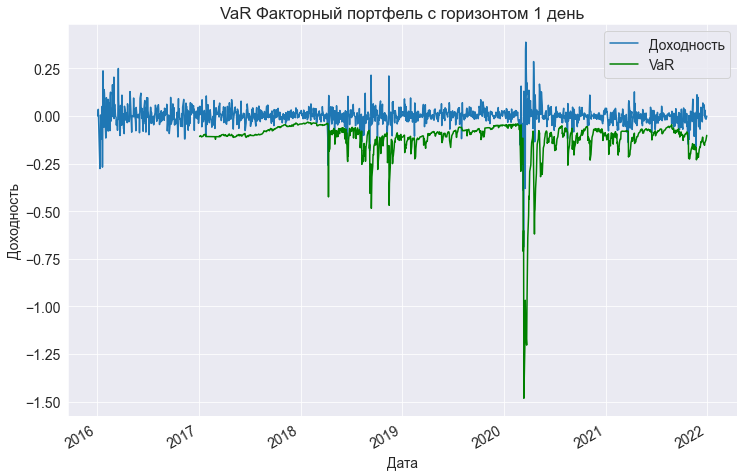

In [7]:
portfolio.plot_value_at_risk(calc_func=calculate_garch)